In [1]:
import pandas as pd
import numpy as np
import textblob
from textblob import TextBlob
import matplotlib.pyplot as plt
import statsmodels.api as sm
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jfern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jfern\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df=pd.read_csv("comments.csv",parse_dates=['created_utc'])
df = df.rename(columns={'created_utc': 'Date'})

In [4]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english", ignore_stopwords=True)
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")

def sentiment_calc(text):
    try:
        token=tokenizer.tokenize(text.lower())
        words=[lemmatizer.lemmatize(w) for w in token if w not in stop_words]
        stem_text=" ".join([stemmer.stem(i) for i in words])
        return TextBlob(stem_text).sentiment.polarity
    except:
        return None
    
df['sentiment'] = df['body'].apply(sentiment_calc)
df2 = df.groupby('Date', as_index=False, sort=False)['sentiment'].mean()
bitcoin=pd.read_csv('Bitcoin_data.csv',parse_dates=['Date'])

In [28]:
bitcoin=pd.read_csv('Bitcoin_data.csv',parse_dates=['Date'])
df_merge=pd.merge(df2, bitcoin, on='Date')
df_merge=df_merge.set_index('Date')
df_merge=df_merge.sort_index()
df_merge["Return"]=df_merge["Close"].pct_change(1)
df_merge=df_merge.dropna()
df_merge["Y"]=np.where(df_merge["Return"]>0,1, 0)

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_merge.Close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print("Critical Values:")
    print(f'{key}, {value}')

ADF Statistic: 4.456492445878286
p-value: 1.0
Critical Values:
1%, -3.432972611342269
Critical Values:
5%, -2.862698654944332
Critical Values:
10%, -2.567386797035513


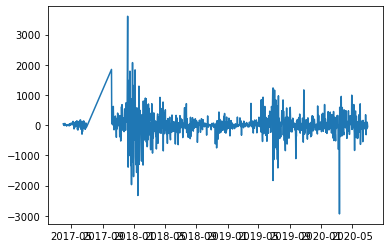

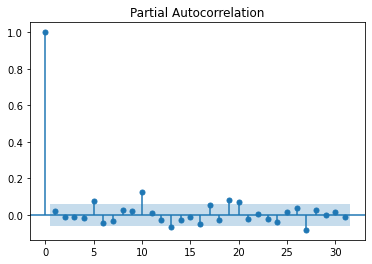

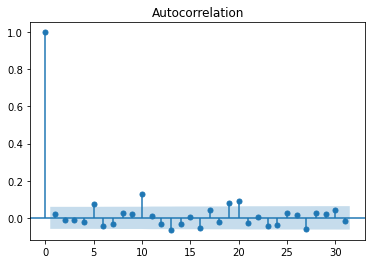

In [7]:
X = df_merge[['sentiment']]
y = df_merge[['Close']]


X_train, y_train= X['2017-03-30':'2020-06-30'],y['2017-03-30':'2020-06-30']
X_test, y_test= X['2020-07-01':],y['2020-07-01':]

plt.plot(y_train.Close.diff())
plot_pacf(y_train.Close.diff().dropna())
plot_acf(y_train.Close.diff().dropna())
plt.show()

In [8]:
model3=sm.tsa.ARIMA(endog=y_train,exog=X_train,order=[1,1,1])
results3=model3.fit(disp=-1)
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1091
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8074.969
Method:                       css-mle   S.D. of innovations            396.429
Date:                Mon, 19 Apr 2021   AIC                          16159.937
Time:                        23:37:35   BIC                          16184.912
Sample:                             1   HQIC                         16169.389
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -84.9443     53.824     -1.578      0.115    -190.437      20.549
sentiment      1426.0846    809.357      1.762      0.078    -160.226    3012.396
ar.L1.D.Close    -0.7288      0.219     

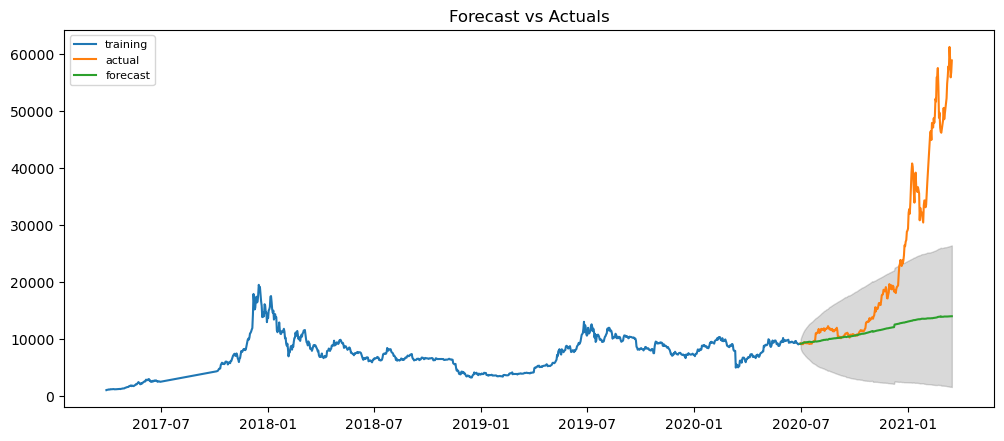

In [9]:
fc, se, conf = results3.forecast(exog = X_test,steps=len(X_test),alpha=0.05)
fc_series = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf[:, 0], index=X_test.index)
upper_series = pd.Series(conf[:, 1], index=X_test.index)


plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label="training")
plt.plot(y_test, label="actual")
plt.plot(fc_series, label="forecast")
plt.fill_between(lower_series.index, lower_series, upper_series,color="k", alpha=.15)
plt.title("Forecast vs Actuals")
plt.legend(loc="upper left", fontsize=8)
plt.show()

In [29]:
forecast=pd.DataFrame(fc_series)
forecast = forecast.rename(columns={0: 'Forecast'})
bitcoin=bitcoin.set_index('Date')
forecast_merge=bitcoin.merge(forecast, how='outer', left_index=True, right_index=True)
forecast_merge.to_csv("Forecasted_data.csv")

In [30]:
X = df_merge[['sentiment',"Volume"]]
y = df_merge['Y']

X_train, y_train= X['2017-03-30':'2020-06-30'],y['2017-03-30':'2020-06-30']
X_test, y_test= X['2020-07-01':],y['2020-07-01':]

In [31]:
knn_clf = KNeighborsClassifier()
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_clf = linear_model.LogisticRegression(solver='liblinear')
svm_clf = SVC(gamma="auto",probability=True)
dectree_clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=100)
gradboost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=10, random_state=0)

clfs = {
'Logistic Regression' : logistic_clf,
'Random Forest': forest_clf,
'Gradient Boosting': gradboost_clf, 
'KNN': knn_clf,
'Decision Tree': dectree_clf,   
'SVM': svm_clf,
}

In [32]:
Results_BL = pd.DataFrame(columns = ['Model', 'CV(5)', 'Accuracy', 'Precision_score', 'Recall_score','F1_score'])
y_pred_list=[]
for model, model_name in zip(clfs.values(), clfs.keys()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score= model.predict_proba(X_test)[:,1]
    Score= cross_val_score(model, X_train, y_train, cv=5).mean()

    t = pd.Series({ 
                     'Model': model_name,
                     'CV(5)': Score,
                     'Accuracy': metrics.accuracy_score(y_test, y_pred),
                     'Precision_score': metrics.precision_score(y_test, y_pred),
                     'Recall_score': metrics.recall_score(y_test, y_pred),                    
                     'F1_score': metrics.f1_score(y_test, y_pred)
                 })

    y_pred_list.append(y_pred)
    Results_BL = Results_BL.append(t,ignore_index = True)

print('Baseline Model:{} predictors used'.format(X_train.shape[1]))
Results_BL

Baseline Model:2 predictors used


,Model,CV(5),Accuracy,Precision_score,Recall_score,F1_score
0,Logistic Regression,0.536630,0.596774,0.596774,1.000000,0.747475
1,Random Forest,0.489959,0.516129,0.598592,0.574324,0.586207
2,Gradient Boosting,0.495438,0.495968,0.578231,0.574324,0.576271
3,KNN,0.501806,0.475806,0.566176,0.520270,0.542254
4,Decision Tree,0.488999,0.528226,0.596273,0.648649,0.621359
5,SVM,0.536630,0.596774,0.596774,1.000000,0.747475


In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        # Normalize by row sums
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around( 100 * cm_pct, decimals=0).astype(int)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


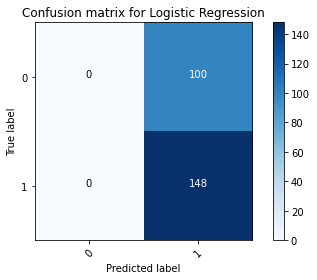

In [37]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[0])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for Logistic Regression')

Confusion matrix, without normalization


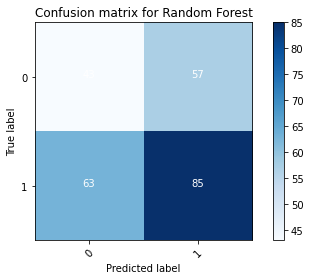

In [38]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[1])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for Random Forest')

Confusion matrix, without normalization


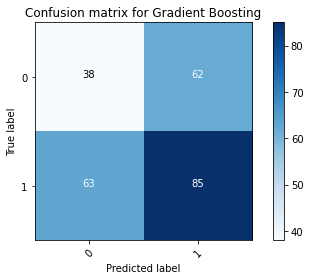

In [41]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[2])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for Gradient Boosting')

Confusion matrix, without normalization


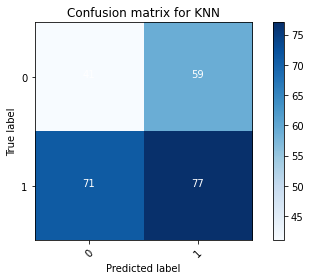

In [43]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[3])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for KNN')

Confusion matrix, without normalization


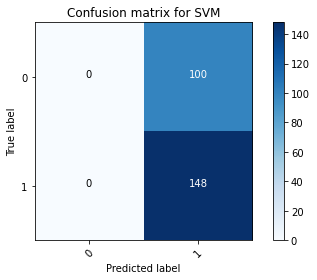

In [44]:
confusion_mat_bl = metrics.confusion_matrix(y_test, y_pred_list[5])
plot_confusion_matrix(confusion_mat_bl, range(2), normalize=False,  title='Confusion matrix for SVM')